In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import pandas as pd

# Q1 - Binomial Tree Methods for Derivatives Valuation and Hedging Parameters Computation

In [2]:
def d1(S, K, T, r, q, sigma):
    """Calculates d1 (BSM)."""
    return (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))

def d2(S, K, T, r, q, sigma, d1_val=None):
    """Calculates d2 (BSM)."""
    if d1_val is None:
        d1_val = d1(S, K, T, r, q, sigma)
    return d1_val - sigma * math.sqrt(T)

def bs_call(S, K, T, r, q, sigma):
    """Calculate the value for a European call option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return S * math.exp(-q * T) * norm.cdf(d1_val) - K * math.exp(-r * T) * norm.cdf(d2_val)

def bs_put(S, K, T, r, q, sigma):
    """Calculate the value for a European put option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return K * math.exp(-r * T) * norm.cdf(-d2_val) - S * math.exp(-q * T) * norm.cdf(-d1_val)

def u_(T, sigma, N):
    """S1 = S0 * u_"""
    dt = T/N
    return np.exp(sigma*np.sqrt(dt))

def d_(T, sigma, N):
    """S1 = S0 * d_"""
    return 1 / u_(T, sigma, N)

In [3]:
def payoffs(V, i, S_temp, K, flag1, flag2):
    if not flag1 and not flag2: # European call
        V[i] = max(S_temp - K, 0)
    elif flag1 and flag2: # American put
        V[i] = max(K - S_temp, 0)
    elif flag1: # European put
        V[i] = max(K - S_temp, 0)
    else: # American call
        V[i] = max(S_temp - K, 0)

In [4]:
def binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = N//2
    if not N % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N+1)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        payoffs(V, i, S_temp1, K, flag1, flag2)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N+1):
        payoffs(V, i, S_temp2, K, flag1, flag2)
        S_temp2 *= u_bar
    
    ## Work backwards through the tree.
    for j in range(N - 1, -1, -1):
        if flag2:
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar
    return V[0]

In [5]:
def avg_binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2) + binomial_pricer(S0, K, T, r, q, sigma, N-1, flag1, flag2))/2 ## Simple average.

In [6]:
def BBS_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = (N-1)//2
    if not (N-1) % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        if not flag1: ## Call option.
            V[i] = bs_call(S_temp1, K, dt, r, q, sigma)
        else: ## Put option.
            V[i] = bs_put(S_temp1, K, dt, r, q, sigma)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N):
        if not flag1:
            V[i] = bs_call(S_temp2, K, dt, r, q, sigma)
        else:
            V[i] = bs_put(S_temp2, K, dt, r, q, sigma)
        S_temp2 *= u_bar
            
    ## Work backwards through the tree.
    for j in range(N - 2, -1, -1):
        if flag2: ## American option.
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar

    return V[0]

In [7]:
def BBSN_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (2*BBS_pricer(S0, K, T, r, q, sigma, N, flag1, flag2) - BBS_pricer(S0, K, T, r, q, sigma, N//2+1, flag1, flag2))

In [8]:
## Option Parameters. ##
S0 = 54
K = 50
T = 1
r = 0.0375
q = 0.01
sigma = 0.29

## Number of time steps to use.
N = np.array([x for x in range(10,101)])

# Arrays for European Put Option Pricing
EP_BT = np.empty(len(N))
EP_ABT = np.empty(len(N))
EP_BBS = np.empty(len(N))
EP_BBSR = np.empty(len(N))

# Arrays for American Put Option Pricing
AP_BT = np.empty(len(N))
AP_ABT = np.empty(len(N))
AP_BBS = np.empty(len(N))
AP_BBSR = np.empty(len(N))

for i in range(len(N)):
    ## European Put Option Pricing.
    EP_BT[i] = binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_ABT[i] = avg_binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_BBS[i] = BBS_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_BBSR[i] = BBSN_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    
    ## American Put Option Pricing.
    AP_BT[i] = binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_ABT[i] = avg_binomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_BBS[i] = BBS_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_BBSR[i] = BBSN_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)

print("BS put price:", bs_put(S0, K, T, r, q, sigma))

BS put price: 3.5794281157157926


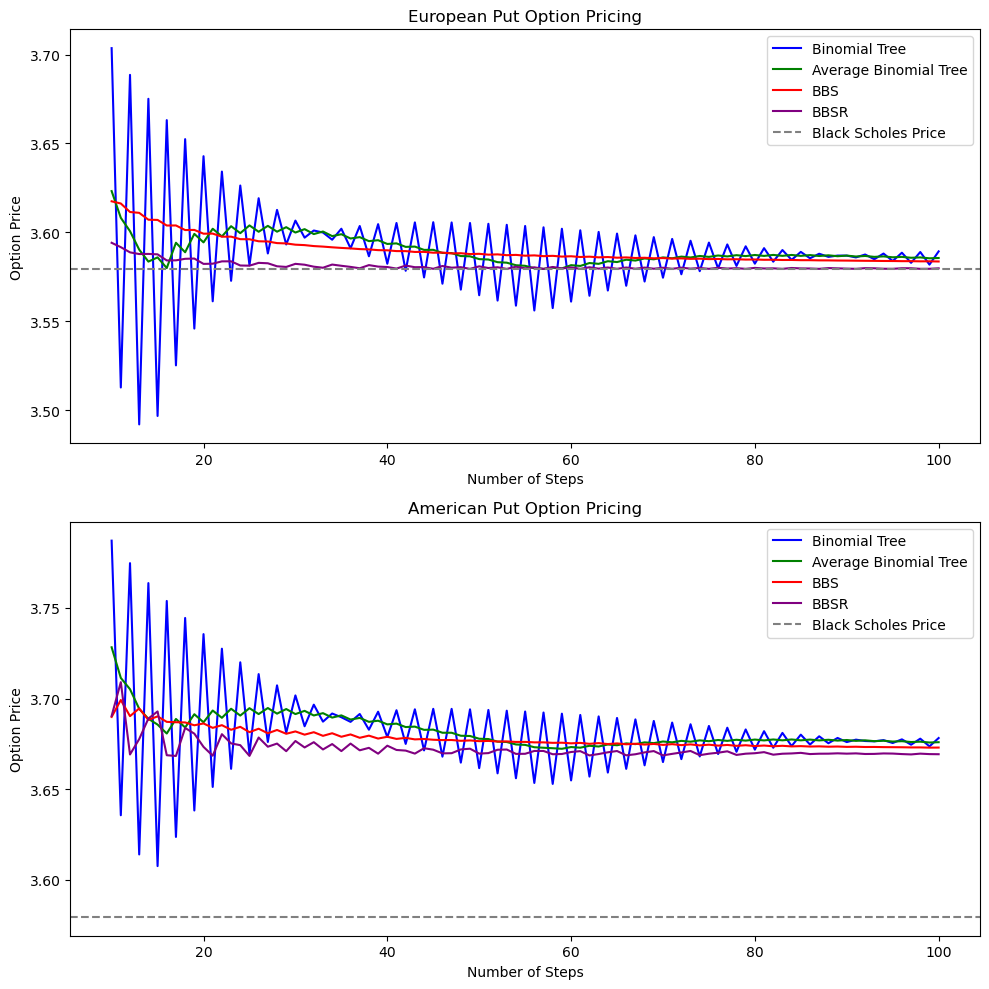

In [9]:
## Plotting Results ##
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# European Put Option Pricing Plot
ax[0].plot(N, EP_BT, label="Binomial Tree", color='blue')
ax[0].plot(N, EP_ABT, label="Average Binomial Tree", color='green')
ax[0].plot(N, EP_BBS, label="BBS", color='red')
ax[0].plot(N, EP_BBSR, label="BBSR", color='purple')
ax[0].axhline(y=bs_put(S0, K, T, r, q, sigma), color='grey', linestyle='--', label="Black Scholes Price")
ax[0].set_title("European Put Option Pricing")
ax[0].set_xlabel("Number of Steps")
ax[0].set_ylabel("Option Price")
ax[0].legend()

# American Put Option Pricing Plot
ax[1].plot(N, AP_BT, label="Binomial Tree", color='blue')
ax[1].plot(N, AP_ABT, label="Average Binomial Tree", color='green')
ax[1].plot(N, AP_BBS, label="BBS", color='red')
ax[1].plot(N, AP_BBSR, label="BBSR", color='purple')
ax[1].axhline(y=bs_put(S0, K, T, r, q, sigma), color='grey', linestyle='--', label="Black Scholes Price")
ax[1].set_title("American Put Option Pricing")
ax[1].set_xlabel("Number of Steps")
ax[1].set_ylabel("Option Price")
ax[1].legend()

plt.tight_layout()
plt.show()


In [10]:
## Create DataFrames for European and American put option estimates.
european_df = pd.DataFrame({
    'N': N,
    'BT': EP_BT,
    'ABT': EP_ABT,
    'BBS': EP_BBS,
    'BBSR': EP_BBSR
})

american_df = pd.DataFrame({
    'N': N,
    'BT': AP_BT,
    'ABT': AP_ABT,
    'BBS': AP_BBS,
    'BBSR': AP_BBSR
})

## Write DataFrames to Excel with one blank row in between.
with pd.ExcelWriter('Put_Estimates.xlsx', engine='openpyxl') as writer:
    european_df.to_excel(writer, sheet_name='Put Estimates', startrow=0, index=False)
    american_df.to_excel(writer, sheet_name='Put Estimates', startrow=len(european_df) + 2, index=False)

print("Data saved to Excel file.")

Data saved to Excel file.


# Q2 - Binomial Tree Methods for European Options

In [11]:
import numpy as np
import pandas as pd 
np.set_printoptions(precision=6)
pd.set_option(
    "display.precision", 6, 
    "display.float_forma", '{:.6f}'.format
)
from enum import IntEnum
from itertools import accumulate
from operator import mul
import unittest
from pprint import pprint

In [12]:
class CallPutType(IntEnum):
    Call = 0
    Put = 1
    
class EuroAmerType(IntEnum):
    EuropeanOption = 0
    AmericanOption = 1
    
def generate_geometric_sequence(start, ratio, length):
    """
    e.g. start = 10, ratio = 2, length = 5
    return [10, 20, 40, 80, 160]
    """
    progression = np.empty(length, dtype=int)
    for i in range(0, length):
        curr_term = start * pow(ratio, i)
        progression[i] = int(curr_term)
    return progression

def delta_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    if call_put_type == CallPutType.Call:
        delta = np.exp(-q*T) * norm.cdf(d1_val)
    elif call_put_type == CallPutType.Put:
        delta = -np.exp(-q*T) * norm.cdf(-d1_val)
    else:
        raise ValueError("invalid call_put_type")
    return delta

def delta_1(V_1_0, V_1_1, S_1_0, S_1_1):
    return (V_1_0 - V_1_1) / (S_1_0 - S_1_1)

def gamma_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    # gammas of C and P are the same for european options
    gamma = np.exp(-q*T) / (S*sigma*np.sqrt(T)) * (1/np.sqrt(2*np.pi)) * np.exp(-d1_val**2/2)
    return gamma

def gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2):
    upper_1 = (V_2_0 - V_2_1) / (S_2_0 - S_2_1)
    upper_2 = (V_2_1 - V_2_2) / (S_2_1 - S_2_2)
    lower = (S_2_0 - S_2_2) / 2
    return (upper_1 - upper_2) / lower

def vega_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    # vegas of C and P are the same for european options
    vega = S * np.exp(-q*T) * np.sqrt(T) * (1/np.sqrt(2*np.pi)) * np.exp(-d1_val**2/2)
    return vega 

def theta_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma)
    if call_put_type == CallPutType.Call:
        theta = (
            -(S*sigma*np.exp(-q*T)) / (2*np.sqrt(2*np.pi*T)) * np.exp(-d1_val**2/2)
            + q * S * np.exp(-q*T) * norm.cdf(d1_val)
            - r * K * np.exp(-r*T) * norm.cdf(d2_val)
        )
    elif call_put_type == CallPutType.Put:
        theta = (
            -(S*sigma*np.exp(-q*T)) / (2*np.sqrt(2*np.pi*T)) * np.exp(-d1_val**2/2) 
            - q * S * np.exp(-q*T) * norm.cdf(-d1_val) 
            + r * K * np.exp(-r*T) * norm.cdf(-d2_val)
        )
    else:
        raise ValueError("Invalid call_put_type")
    return theta

def theta_1(V_2_1, V_0_0, T, N):
    dt = T/N
    return (V_2_1 - V_0_0) / (2*dt)

def binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    """
    This is a modication of Kevin's binomial pricer
    In order to get V_1_0, V_1_1, V_2_0, V_2_1, V_2_2, ...
    Args:
        early_stop: the nth step from V_0
    """
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = N//2
    if not N % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N+1)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        payoffs(V, i, S_temp1, K, flag1, flag2)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N+1):
        payoffs(V, i, S_temp2, K, flag1, flag2)
        S_temp2 *= u_bar
    
    ## Work backwards through the tree.
    for j in range(N - 1, -1+early_stop, -1):
        if flag2:
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar
    return V[:(early_stop+1)]

In [13]:
class TestNotebook(unittest.TestCase):
    
    def test_generate_geometric_sequence(self):
        sequence = generate_geometric_sequence(10, 2, 5)
        assert np.array_equal(
            sequence, 
            [10, 20, 40, 80, 160]
        )
        
    def test_binomial_pricer_early_stop(self):
        S0 = 54
        K = 50
        T = 1
        r = 0.0375
        q = 0.01
        sigma = 0.29
        N = 100
        
        reference = binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, early_stop=0)[0]
        target = binomial_pricer(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption)
        assert np.isclose(reference, target)
        
    def test_binomial_pricer_early_stop_order(self):
        S0 = 54
        K = 50
        T = 1
        r = 0.0375
        q = 0.01
        sigma = 0.29
        N = 100
        
        values = binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, early_stop=2)
        assert len(values) == 3
        assert values[0] >= values[1] and values[1] >= values[2]
        
    def test_u_d(self):
        T = 1
        sigma = 0.29
        N = 100
        u = u_(T, sigma, N)
        d = d_(T, sigma, N)
        assert np.isclose(u*d, 1.0)


unittest.main(argv=[''], verbosity=6, exit=False)

test_binomial_pricer_early_stop (__main__.TestNotebook.test_binomial_pricer_early_stop) ... ok
test_binomial_pricer_early_stop_order (__main__.TestNotebook.test_binomial_pricer_early_stop_order) ... ok
test_generate_geometric_sequence (__main__.TestNotebook.test_generate_geometric_sequence) ... ok
test_u_d (__main__.TestNotebook.test_u_d) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


### Black Scholes Pricing

In [14]:
V_BS = bs_put(S0, K, T, r, q, sigma)
Delta_BS = delta_bs_european(S0, K, T, r, q, sigma, CallPutType.Put) 
Gamma_BS = gamma_bs_european(S0, K, T, r, q, sigma, CallPutType.Put)
Theta_BS = theta_bs_european(S0, K, T, r, q, sigma, CallPutType.Put)

black_scholes_res = pd.DataFrame({
    "V_BS": V_BS,
    "Delta_BS": Delta_BS,
    "Gamma_BS": Gamma_BS,
    "Theta_BS": Theta_BS,
}, index=[0])
pprint(black_scholes_res)


      V_BS  Delta_BS  Gamma_BS  Theta_BS
0 3.579428 -0.303654  0.022200 -2.136950


In [15]:
def approximation_error(reference, target):
    return abs(reference-target)

def linear_approximation_error(reference, target, N):
    return N * approximation_error(reference, target)

def quadratic_approximation_error(reference, target, N):
    return N**2 * approximation_error(reference, target)

### Binomial Tree

In [16]:
# Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_BT = np.empty(len(N))
EP_BT_approximation_error = np.empty(len(N))
EP_BT_linear_approximation_error = np.empty(len(N))
EP_BT_quadratic_approximation_error = np.empty(len(N))

EP_BT_delta = np.empty(len(N))
EP_BT_delta_error = np.empty(len(N))
EP_BT_gamma = np.empty(len(N))
EP_BT_gamma_error = np.empty(len(N))
EP_BT_theta = np.empty(len(N))
EP_BT_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption)
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_BT[i] = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption)
    
    # approximation error
    EP_BT_approximation_error[i] = approximation_error(EP_BT[i], V_BS)
    EP_BT_linear_approximation_error[i] = linear_approximation_error(EP_BT[i], V_BS, N[i])
    EP_BT_quadratic_approximation_error[i] = quadratic_approximation_error(EP_BT[i], V_BS, N[i])
    
    EP_BT_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_BT_delta_error[i] = approximation_error(EP_BT_delta[i] , Delta_BS)
    EP_BT_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_BT_gamma_error[i] = approximation_error(EP_BT_gamma[i], Gamma_BS)
    EP_BT_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_BT_theta_error[i] = approximation_error(EP_BT_theta[i], Theta_BS)
    
binomial_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_BT,
    "|V(N) - V_BS|": EP_BT_approximation_error, 
    "N|V(N) - V_BS|": EP_BT_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_BT_quadratic_approximation_error,
    "Delta_1": EP_BT_delta,
    "|Delta_1 - Delta_BS|": EP_BT_delta_error,
    "Gamma_1": EP_BT_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_BT_gamma_error,
    "Theta_1": EP_BT_theta,
    "|Theta_1 - Theta_BS|": EP_BT_theta_error,
})

binomial_tree_res

,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,10,3.703631,0.124202,1.242025,12.420250,0.306502,0.610156,0.011641,0.010559,-2.227566,0.090616
1,20,3.642832,0.063404,1.268083,25.361669,0.304525,0.608179,0.011277,0.010923,-2.178015,0.041065
2,40,3.582311,0.002882,0.115300,4.611987,0.303623,0.607277,0.011238,0.010962,-2.172174,0.035224
3,80,3.582365,0.002936,0.234918,18.793401,0.303807,0.607461,0.011089,0.011111,-2.154212,0.017262
4,160,3.585679,0.006251,1.000199,160.031855,0.303748,0.607402,0.011000,0.011199,-2.142895,0.005945
5,320,3.583016,0.003588,1.148124,367.399785,0.303721,0.607375,0.010975,0.011225,-2.139740,0.002790
6,640,3.581148,0.001719,1.100460,704.294342,0.303686,0.607339,0.010965,0.011235,-2.138379,0.001429
7,1280,3.579952,0.000524,0.671047,858.940688,0.303663,0.607317,0.010960,0.011240,-2.137825,0.000876


### Average Black-Scholes Tree

In [17]:
def avg_binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (
        binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop) 
        + binomial_pricer_early_stop(S0, K, T, r, q, sigma, N-1, flag1, flag2, early_stop)
    )/2 ## Simple average.

In [18]:
# Average Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_ABT = np.empty(len(N))
EP_ABT_approximation_error = np.empty(len(N))
EP_ABT_linear_approximation_error = np.empty(len(N))
EP_ABT_quadratic_approximation_error = np.empty(len(N))

EP_ABT_delta = np.empty(len(N))
EP_ABT_delta_error = np.empty(len(N))
EP_ABT_gamma = np.empty(len(N))
EP_ABT_gamma_error = np.empty(len(N))
EP_ABT_theta = np.empty(len(N))
EP_ABT_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = avg_binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = avg_binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = avg_binomial_pricer(
        S0, K, T, r, q, sigma, N[i]+1, CallPutType.Put, EuroAmerType.EuropeanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_ABT[i] = avg_binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption)
    
    # approximation error
    EP_ABT_approximation_error[i] = approximation_error(EP_ABT[i], V_BS)
    EP_ABT_linear_approximation_error[i] = linear_approximation_error(EP_ABT[i], V_BS, N[i])
    EP_ABT_quadratic_approximation_error[i] = quadratic_approximation_error(EP_ABT[i], V_BS, N[i])
    
    EP_ABT_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_ABT_delta_error[i] = approximation_error(EP_ABT_delta[i] , Delta_BS)
    EP_ABT_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_ABT_gamma_error[i] = approximation_error(EP_ABT_gamma[i], Gamma_BS)
    EP_ABT_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_ABT_theta_error[i] = approximation_error(EP_ABT_theta[i], Theta_BS)
    
average_binomial_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_ABT,
    "|V(N) - V_BS|": EP_ABT_approximation_error, 
    "N|V(N) - V_BS|": EP_ABT_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_ABT_quadratic_approximation_error,
    "Delta_1": EP_ABT_delta,
    "|Delta_1 - Delta_BS|": EP_ABT_delta_error,
    "Gamma_1": EP_ABT_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_ABT_gamma_error,
    "Theta_1": EP_ABT_theta,
    "|Theta_1 - Theta_BS|": EP_ABT_theta_error,
})

average_binomial_tree_res

,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,10,3.623203,0.043775,0.437746,4.377459,0.297369,0.601022,0.011342,0.010858,-2.167177,0.030227
1,20,3.594339,0.014911,0.298211,5.964216,0.300565,0.604219,0.011106,0.011094,-2.146797,0.009847
2,40,3.593456,0.014028,0.561109,22.444364,0.302062,0.605716,0.011016,0.011184,-2.139979,0.003029
3,80,3.587250,0.007822,0.625780,50.062433,0.302869,0.606523,0.010984,0.011216,-2.138349,0.001399
4,160,3.583019,0.003591,0.574518,91.922843,0.303261,0.606915,0.010968,0.011232,-2.137526,0.000576
5,320,3.580991,0.001562,0.499971,159.990793,0.303449,0.607103,0.010962,0.011238,-2.137445,0.000495
6,640,3.580267,0.000839,0.536713,343.496566,0.303553,0.607206,0.010958,0.011242,-2.137160,0.000210
7,1280,3.579932,0.000504,0.644682,825.193216,0.303605,0.607258,0.010955,0.011245,-2.137001,0.000051


### Binomial Black-Scholes

In [19]:
def BBS_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = (N-1)//2
    if not (N-1) % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        if not flag1: ## Call option.
            V[i] = bs_call(S_temp1, K, dt, r, q, sigma)
        else: ## Put option.
            V[i] = bs_put(S_temp1, K, dt, r, q, sigma)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N):
        if not flag1:
            V[i] = bs_call(S_temp2, K, dt, r, q, sigma)
        else:
            V[i] = bs_put(S_temp2, K, dt, r, q, sigma)
        S_temp2 *= u_bar
            
    ## Work backwards through the tree.
    for j in range(N - 2, -1+early_stop, -1):
        if flag2: ## American option.
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar

    return V[:(early_stop+1)]

In [20]:
# Black Scholes Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(10, 2, 8) # {10, 20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_BBS = np.empty(len(N))
EP_BBS_approximation_error = np.empty(len(N))
EP_BBS_linear_approximation_error = np.empty(len(N))
EP_BBS_quadratic_approximation_error = np.empty(len(N))

EP_BBS_delta = np.empty(len(N))
EP_BBS_delta_error = np.empty(len(N))
EP_BBS_gamma = np.empty(len(N))
EP_BBS_gamma_error = np.empty(len(N))
EP_BBS_theta = np.empty(len(N))
EP_BBS_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = BBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = BBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = BBS_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_BBS[i] = BBS_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    
    # approximation error
    EP_BBS_approximation_error[i] = approximation_error(EP_BBS[i], V_BS)
    EP_BBS_linear_approximation_error[i] = linear_approximation_error(EP_BBS[i], V_BS, N[i])
    EP_BBS_quadratic_approximation_error[i] = quadratic_approximation_error(EP_BBS[i], V_BS, N[i])
    
    EP_BBS_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_BBS_delta_error[i] = approximation_error(EP_BBS_delta[i] , Delta_BS)
    EP_BBS_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_BBS_gamma_error[i] = approximation_error(EP_BBS_gamma[i], Gamma_BS)
    EP_BBS_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_BBS_theta_error[i] = approximation_error(EP_BBS_theta[i], Theta_BS)
    
BBS_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_BBS,
    "|V(N) - V_BS|": EP_BBS_approximation_error, 
    "N|V(N) - V_BS|": EP_BBS_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_BBS_quadratic_approximation_error,
    "Delta_1": EP_BBS_delta,
    "|Delta_1 - Delta_BS|": EP_BBS_delta_error,
    "Gamma_1": EP_BBS_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_BBS_gamma_error,
    "Theta_1": EP_BBS_theta,
    "|Theta_1 - Theta_BS|": EP_BBS_theta_error,
})

BBS_tree_res


,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,10,3.617453,0.038025,0.380251,3.802509,0.304397,0.608050,0.012106,0.010094,-2.281462,0.144512
1,20,3.599228,0.019800,0.396005,7.920103,0.304118,0.607771,0.011488,0.010712,-2.204251,0.067301
2,40,3.589882,0.010454,0.418150,16.725992,0.303903,0.607557,0.011209,0.010991,-2.169205,0.032255
3,80,3.584714,0.005286,0.422893,33.831461,0.303774,0.607428,0.011079,0.011121,-2.152787,0.015837
4,160,3.582031,0.002603,0.416491,66.638588,0.303716,0.607370,0.011016,0.011184,-2.144844,0.007895
5,320,3.580729,0.001301,0.416413,133.252032,0.303684,0.607338,0.010985,0.011215,-2.140880,0.003930
6,640,3.580081,0.000652,0.417545,267.228599,0.303669,0.607323,0.010969,0.011231,-2.138911,0.001961
7,1280,3.579758,0.000330,0.422156,540.360008,0.303662,0.607315,0.010961,0.011239,-2.137928,0.000978


### Binomial Black-Scholes with Richardson Extrapolation

In [21]:
def BBSN_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (
        2*BBS_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop) 
        - BBS_pricer_early_stop(S0, K, T, r, q, sigma, N//2+1, flag1, flag2, early_stop)
    )


In [22]:
# Richardson Extrapolation Binomial Tree
# number of steps to use 
N = generate_geometric_sequence(20, 2, 7) # {20, 40, ..., 1280}

# Arrays for European Put Option Pricing
EP_BBRN = np.empty(len(N))
EP_BBSN_approximation_error = np.empty(len(N))
EP_BBSN_linear_approximation_error = np.empty(len(N))
EP_BBSN_quadratic_approximation_error = np.empty(len(N))

EP_BBSN_delta = np.empty(len(N))
EP_BBSN_delta_error = np.empty(len(N))
EP_BBSN_gamma = np.empty(len(N))
EP_BBSN_gamma_error = np.empty(len(N))
EP_BBSN_theta = np.empty(len(N))
EP_BBSN_theta_error = np.empty(len(N))

for i in range(len(N)):
    # preparation
    V_1_0, V_1_1 = BBSN_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = BBSN_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    V_0_0 = BBSN_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    # value from binomial tree pricer
    EP_BBRN[i] = BBSN_pricer(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption
    )
    
    # approximation error
    EP_BBSN_approximation_error[i] = approximation_error(EP_BBRN[i], V_BS)
    EP_BBSN_linear_approximation_error[i] = linear_approximation_error(EP_BBRN[i], V_BS, N[i])
    EP_BBSN_quadratic_approximation_error[i] = quadratic_approximation_error(EP_BBRN[i], V_BS, N[i])
    
    EP_BBSN_delta[i] = delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    EP_BBSN_delta_error[i] = approximation_error(EP_BBSN_delta[i] , Delta_BS)
    EP_BBSN_gamma[i] = gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    EP_BBSN_gamma_error[i] = approximation_error(EP_BBSN_gamma[i], Gamma_BS)
    EP_BBSN_theta[i] = theta_1(V_2_1, V_0_0, T, N[i])
    EP_BBSN_theta_error[i] = approximation_error(EP_BBSN_theta[i], Theta_BS)
    
BBSN_tree_res = pd.DataFrame({
    "N": N,
    "V(N)": EP_BBRN,
    "|V(N) - V_BS|": EP_BBSN_approximation_error, 
    "N|V(N) - V_BS|": EP_BBSN_linear_approximation_error,
    "N^2|V(N) - V_BS|": EP_BBSN_quadratic_approximation_error,
    "Delta_1": EP_BBSN_delta,
    "|Delta_1 - Delta_BS|": EP_BBSN_delta_error,
    "Gamma_1": EP_BBSN_gamma, 
    "|Gamma_1 - Gamma_BS|":EP_BBSN_gamma_error,
    "Theta_1": EP_BBSN_theta,
    "|Theta_1 - Theta_BS|": EP_BBSN_theta_error,
})

BBSN_tree_res


,N,V(N),|V(N) - V_BS|,N|V(N) - V_BS|,N^2|V(N) - V_BS|,Delta_1,|Delta_1 - Delta_BS|,Gamma_1,|Gamma_1 - Gamma_BS|,Theta_1,|Theta_1 - Theta_BS|
0,20,3.582237,0.002809,0.056186,1.123721,0.197398,0.501052,-0.001439,0.023639,-0.291168,1.845782
1,40,3.580478,0.001050,0.041992,1.679682,0.187991,0.491645,-0.002356,0.024555,-0.148205,1.988745
2,80,3.579988,0.000559,0.044756,3.580466,0.183001,0.486655,-0.002824,0.025024,-0.074436,2.062514
3,160,3.579513,0.000085,0.013650,2.183941,0.180451,0.484105,-0.003057,0.025257,-0.037500,2.099450
4,320,3.579393,0.000035,0.011283,3.610707,0.179169,0.482822,-0.003175,0.025375,-0.018884,2.118066
5,640,3.579402,0.000026,0.016694,10.684464,0.178523,0.482176,-0.003234,0.025434,-0.009456,2.127494
6,1280,3.579421,0.000007,0.008547,10.940227,0.178200,0.481854,-0.003264,0.025464,-0.004728,2.132222


In [23]:
rows = 0
tables = [
    black_scholes_res, 
    binomial_tree_res,
    average_binomial_tree_res,
    BBS_tree_res,
    BBSN_tree_res,
]

with pd.ExcelWriter('binomial_tree_methods_for_european_options.xlsx', engine='openpyxl') as writer:
    for i in range(len(tables)):
        t = tables[i]
        t.to_excel(writer, sheet_name='estimates', startrow=rows, index=False)
        rows += len(t) + 2
        
